In [1]:
import os 
import numpy as np 

### MNIST

In [4]:
from models import Net
from data import FEMNIST_dataset, Partition_MNIST_NIID
from data import MNIST_NIID_dataset
import tensorflow.keras as tk
#import yaml 
import random 

### Divide MNIST dataset over a total of 10 clients. Each client gets 2 classes.
train_data, test_data = tk.datasets.mnist.load_data()
instance = Partition_MNIST_NIID(train_data[0],train_data[1])
classes_per_user = 2 
total_clients = 100
n_classes_total = 4 
train_partition = instance.create_partition(n_classes_total,classes_per_user,total_clients)
test_instance = Partition_MNIST_NIID(test_data[0], test_data[1])
test_partition = test_instance.create_partition_test(instance.sample_array)

[[1 2]
 [0 1]
 [0 1]
 [3 1]
 [3 0]
 [0 1]
 [0 1]
 [3 2]
 [0 2]
 [3 1]
 [1 2]
 [0 1]
 [0 3]
 [0 2]
 [0 1]
 [1 3]
 [0 2]
 [1 3]
 [3 2]
 [1 3]
 [1 2]
 [1 3]
 [2 0]
 [3 2]
 [0 3]
 [2 0]
 [2 3]
 [3 2]
 [1 3]
 [2 3]
 [3 2]
 [3 2]
 [0 1]
 [1 2]
 [3 1]
 [1 3]
 [2 0]
 [3 2]
 [0 3]
 [3 1]
 [3 2]
 [0 1]
 [0 1]
 [3 2]
 [1 0]
 [1 0]
 [1 2]
 [1 3]
 [2 3]
 [2 1]
 [2 3]
 [0 1]
 [1 2]
 [1 3]
 [0 1]
 [2 3]
 [1 2]
 [3 1]
 [2 1]
 [2 0]
 [2 1]
 [0 3]
 [1 2]
 [1 0]
 [2 0]
 [0 3]
 [0 1]
 [0 1]
 [1 3]
 [0 2]
 [1 3]
 [2 0]
 [1 0]
 [2 3]
 [1 2]
 [2 3]
 [2 1]
 [2 1]
 [3 0]
 [0 1]
 [3 1]
 [3 0]
 [2 0]
 [2 3]
 [1 2]
 [3 0]
 [1 0]
 [3 0]
 [0 2]
 [1 3]
 [3 2]
 [1 2]
 [3 0]
 [0 1]
 [2 3]
 [3 0]
 [2 0]
 [1 0]
 [2 0]
 [0 1]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


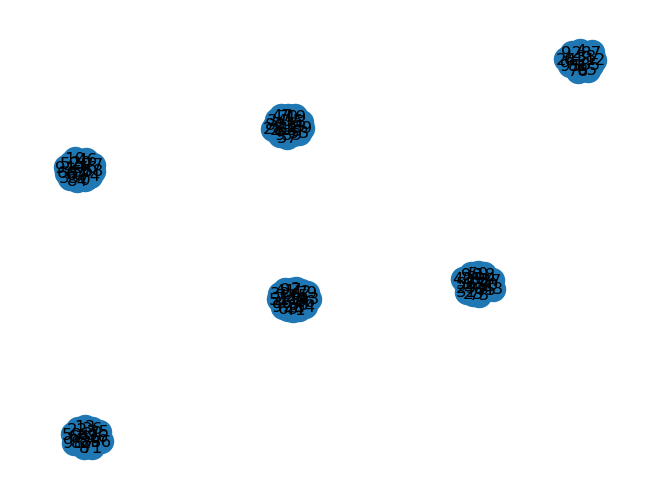

In [6]:
# who do we expect to collaborate based on labels? 
import networkx as nx 
def Repeat(x):
    _size = len(x)
    repeated = []
    cit = {}
    for i in range(_size):
        k = i + 1 
        key = str(np.sort(x[i,:]))
        if key not in cit: 
            cit[key] = [i]
            
        for j in range(k, _size):
            if x[i,0] == x[j,0] and x[i,1] == x[j,1]: #and x[i,:] not in repeated:
                repeated.append(x[i,:])
                if j not in cit[key]: 
                    cit[key].append(j)
            if x[i,0] == x[j,1] and x[i,1] == x[j,0]: #and x[i,:] and x[j,:] not in repeated:
                repeated.append(x[i,:])
                if j not in cit[key]:
                    cit[key].append(j)
                
    return cit 

cit = Repeat(instance.sample_array)
GS = nx.DiGraph()
adj_matrix = np.zeros((total_clients,total_clients))
for p in cit.keys():
    arr = cit[p] 
    for i in arr:
        for j in arr:
            if i != j: 
                GS.add_edge(i,j)
                adj_matrix[i,j] += 1 
nx.draw(GS,with_labels=True)
print(adj_matrix)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 10. ... 34.  0.  1.]
 [ 0.  2.  0. ...  2.  0.  1.]
 ...
 [ 0. 45.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]
19752.0
269.0
48506.0
51494.0


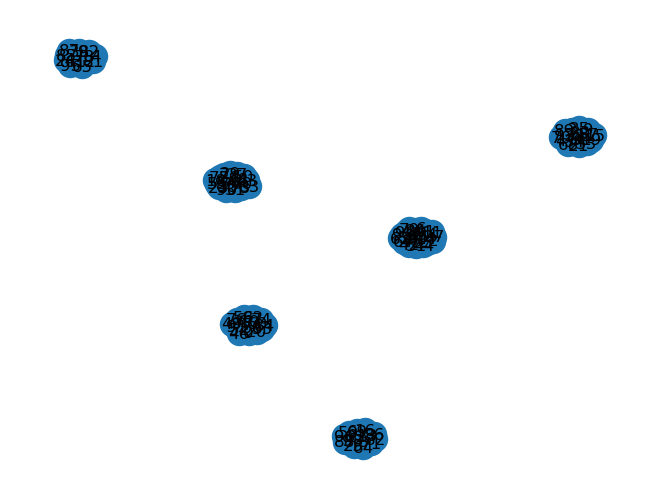

In [7]:
old = 0 
old_tried = 0 
experiment = 'bandits_24_10_2'
new_tried = []
new = []
regret = []
i = 99
phi = np.loadtxt(os.path.join('checkpoints_bandits',experiment,'phi'+str(i)+'.txt'))
phi_UCB = np.loadtxt(os.path.join('checkpoints_bandits',experiment,'phi_UCB'+str(i)+'.txt'))
print(phi)
print(adj_matrix)

# who do we expect to collaborate based on labels? 
import networkx as nx 
def Repeat(x):
    _size = len(x)
    repeated = []
    cit = {}
    for i in range(_size):
        k = i + 1 
        key = str(np.sort(x[i,:]))
        if key not in cit: 
            cit[key] = [i]
            
        for j in range(k, _size):
            if x[i,0] == x[j,0] and x[i,1] == x[j,1]: #and x[i,:] not in repeated:
                repeated.append(x[i,:])
                if j not in cit[key]: 
                    cit[key].append(j)
            if x[i,0] == x[j,1] and x[i,1] == x[j,0]: #and x[i,:] and x[j,:] not in repeated:
                repeated.append(x[i,:])
                if j not in cit[key]:
                    cit[key].append(j)
                
    return cit 

cit = Repeat(instance.sample_array)
GS = nx.DiGraph()
adj_matrix = np.zeros((total_clients,total_clients))
for p in cit.keys():
    arr = cit[p] 
    for i in arr:
        for j in arr:
            if i != j: 
                GS.add_edge(i,j)
                adj_matrix[i,j] += 1 
nx.draw(GS,with_labels=True)
print(adj_matrix)

within_cluster = 0 
outside_cluster = 0 
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        if adj_matrix[i,j]==1: 
            within_cluster += phi[i,j]
        else: 
            outside_cluster += phi[i,j]
            
# Total purity
print(within_cluster)
print(outside_cluster)            

within_cluster = 0 
outside_cluster = 0 
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        if adj_matrix[i,j]==1:
            within_cluster += phi_UCB[i,j]
        else: 
            outside_cluster += phi_UCB[i,j]
print(within_cluster)
print(outside_cluster)  

### MIT-BIH

In [34]:
experiment = "MIT_bandits_10_1"
phi = np.loadtxt(os.path.join('checkpoints_bandits',experiment,'phi'+str(i)+'.txt'))

In [35]:
import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict 
import pickle
import json
import wfdb
import pandas as pd

def read_dict_beats():
    with open(DICT_BEATS, "rb") as f:
        return pickle.load(f)
    
def read_data_beats():
    with open(DATA_BEATS, "rb") as f:
        return pickle.load(f)
    
def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")
            
        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")

DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
print(RECORDS)
patient_ids = pd.read_csv(RECORDS,  header=None).to_numpy().reshape(-1)
print(patient_ids)
def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([105, 114, 201, 202,207, 209, 213, 222, 223, 234]) # according to paper 
print(np.concatenate((paced_patients,excluded_patients)))


dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/RECORDS
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]
[102 104 107 217 105 114 201 202 207 209 213 222 223 234]


In [36]:
def train_test_split(data_beats,seconds=5,factor=0.8): 
    data_beats_train = {}
    data_beats_val = {}
    data_beats_test = {}
    for i in data_beats.keys(): 
        data_beats_train[i] = {'class':None, 'beats':None}
        data_beats_val[i] = {'class':None, 'beats':None}
        data_beats_test[i] ={'class':None, 'beats':None}
    
    for patient in data_beats.keys(): 
        length = int(np.ceil(len(data_beats[patient]['beats'])*(seconds/30))) # only take first 5 seconds
        
        random_test = np.arange(length)
        random_train = np.random.choice(random_test,size=int(np.ceil(0.8*length)),replace=False)
        for ii in random_train: 
            index = np.where(random_test == ii)[0]
            random_test = np.delete(random_test,index)
            
        random_val = np.arange(int(np.ceil(0.8*length)))
        random_train = np.random.choice(random_val,size=int(np.ceil(0.8*0.8*length)),replace=False)
        for ii in random_train: 
            index = np.where(random_val == ii)[0]
            random_val = np.delete(random_val,index)
 
        data_beats_train[patient]['class'] = data_beats[patient]['class'][np.sort(random_train)]
        data_beats_test[patient]['class'] = data_beats[patient]['class'][random_test]
        data_beats_val[patient]['class'] = data_beats[patient]['class'][random_val]
        data_beats_train[patient]['beats'] = data_beats[patient]['beats'][np.sort(random_train)]
        data_beats_test[patient]['beats'] = data_beats[patient]['beats'][random_test]
        data_beats_val[patient]['beats'] = data_beats[patient]['beats'][random_val]
        
    
    return data_beats_train, data_beats_val, data_beats_test 
#print(data_beats_train)
seconds = 5
data_beats_train, data_beats_val, data_beats_test  = train_test_split(data_beats,seconds)

In [37]:
#print(np.shape(dict_beats))
import collections
import copy
print(dict_beats.keys())
patients_out = np.concatenate((paced_patients,excluded_patients))
print(patients_out)
patients_left = list(copy.deepcopy(patient_ids))

for idx,i in enumerate(patient_ids):
    if i in patients_out: 
        patients_left.remove(i)
        
print(patients_left)

#print(dict_beats[101]['beats'])
#print(dict_beats[101]['class'])
labels = ['N','V','S','Q','F']
dictionary = {}
for i in labels: 
    dictionary[i] = 0
    
list1 = []
array = np.zeros((len(patients_left),2))
labels2 = []
for idx,i in enumerate(patients_left):
    for ii in data_beats[i]['label']:
        if ii not in labels2: 
            labels2.append(ii)
    #print(len(data_beats[i]['class']))
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx,0] += counter[j]
        else: 
            array[idx,1] += counter[j]
print(labels2)

dict_keys([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234])
[102 104 107 217 105 114 201 202 207 209 213 222 223 234]
[100, 101, 103, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 203, 205, 208, 210, 212, 214, 215, 219, 220, 221, 228, 230, 231, 232, 233]
['N', 'A', 'V', 'Q', 'F', 'j', 'L', 'a', 'R', 'J', 'S', 'E']


In [38]:
import torch
seconds = 5
data_beats_train, data_beats_val, data_beats_test  = train_test_split(data_beats,seconds)
patients_healthy = []
patients_really_unhealthy = [] 
patients_semi_unhealthy = []
label_dict = {}
n_total = 0 
abn_total = 0 
for i in range(len(patients_left)): 
    
    mit_bih = MIT_BIH([patients_left[i]],data_beats_train)
    #print('train ',torch.sum(mit_bih.y).numpy()/len(mit_bih.y))
    fraction_train = torch.sum(mit_bih.y).numpy()/len(mit_bih.y) 
    mit_bih = MIT_BIH([patients_left[i]],data_beats_test)
    #print('test ',torch.sum(mit_bih.y).numpy()/len(mit_bih.y))
    fraction_test = torch.sum(mit_bih.y).numpy()/len(mit_bih.y) 
    #if fraction_train + fraction_test == 0: 
   #     patients_healthy.append(i)
   #     print('patient ',patients_left[i])
   #     label_dict[i] = 0 
   # else: 

    N = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='N') +np.count_nonzero(data_beats_val[patients_left[i]]['class']=='N')+np.count_nonzero(data_beats_test[patients_left[i]]['class']=='N')
    V = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='V') +np.count_nonzero(data_beats_val[patients_left[i]]['class']=='V')+np.count_nonzero(data_beats_test[patients_left[i]]['class']=='V')
    S = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='S') +np.count_nonzero(data_beats_val[patients_left[i]]['class']=='S') +np.count_nonzero(data_beats_test[patients_left[i]]['class']=='S') 
    F = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='F') + np.count_nonzero(data_beats_val[patients_left[i]]['class']=='F') + np.count_nonzero(data_beats_test[patients_left[i]]['class']=='F')
    n_total += N 
    abn_total += V + S + F
    print('patient ',patients_left[i])
    print('N: ',N)
    print('V: ',V)
    print('S: ',S)
    print('F: ',F)
    if V+S+F >= 10: 
        patients_really_unhealthy.append(i)
        label_dict[i] = 2
    else: 
        patients_healthy.append(i)
        label_dict[i] = 0
print('healthy patients: ',patients_healthy)
print('very unhealthy patients: ',patients_really_unhealthy)

patient  100
N:  376
V:  0
S:  3
F:  0
patient  101
N:  311
V:  0
S:  0
F:  0
patient  103
N:  347
V:  0
S:  0
F:  0
patient  106
N:  268
V:  70
S:  0
F:  0
patient  108
N:  291
V:  3
S:  0
F:  0
patient  109
N:  414
V:  6
S:  0
F:  2
patient  111
N:  354
V:  0
S:  0
F:  0
patient  112
N:  423
V:  0
S:  0
F:  0
patient  113
N:  298
V:  0
S:  1
F:  0
patient  115
N:  326
V:  0
S:  0
F:  0
patient  116
N:  395
V:  7
S:  0
F:  0
patient  117
N:  256
V:  0
S:  0
F:  0
patient  118
N:  364
V:  5
S:  11
F:  0
patient  119
N:  251
V:  80
S:  0
F:  0
patient  121
N:  311
V:  0
S:  0
F:  0
patient  122
N:  413
V:  0
S:  0
F:  0
patient  123
N:  253
V:  0
S:  0
F:  0
patient  124
N:  264
V:  3
S:  3
F:  0
patient  200
N:  292
V:  139
S:  3
F:  0
patient  203
N:  427
V:  67
S:  3
F:  0
patient  205
N:  442
V:  1
S:  0
F:  0
patient  208
N:  267
V:  161
S:  0
F:  65
patient  210
N:  407
V:  32
S:  1
F:  2
patient  212
N:  458
V:  0
S:  0
F:  0
patient  214
N:  336
V:  41
S:  0
F:  0
patient  215
N

[100, 101, 103, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 203, 205, 208, 210, 212, 214, 215, 219, 220, 221, 228, 230, 231, 232, 233]
{0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0}
{0: 0, 3: 1, 5: 0, 10: 2, 12: 2, 13: 2, 17: 2, 18: 3, 19: 1, 21: 1, 22: 0, 24: 3, 25: 1, 26: 0, 28: 3, 29: 1, 31: 1, 32: 1, 33: 3}
['100 : 0', '106 : 1', '109 : 0', '116 : 2', '118 : 2', '119 : 2', '124 : 2', '200 : 3', '203 : 1', '208 : 1', '210 : 0', '214 : 3', '215 : 1', '219 : 0', '221 : 3', '228 : 1', '231 : 1', '232 : 1', '233 : 3']
[0, 1, 0, 2, 2, 2, 2, 3, 1, 1, 0, 3, 1, 0, 3, 1, 1, 1, 3]


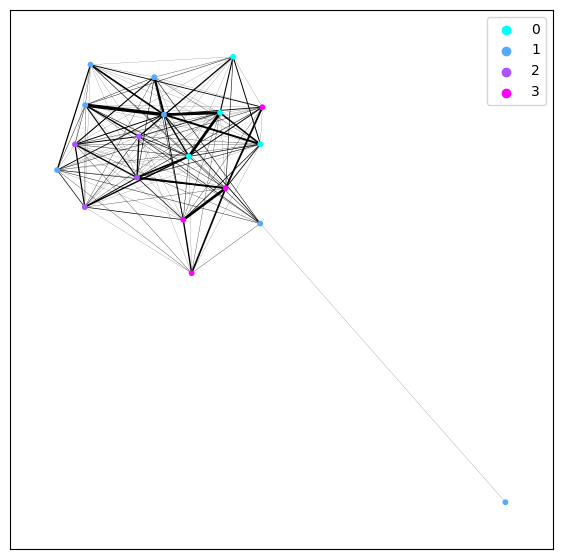

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#print(phi)
phi_binary =np.array(np.array(phi,dtype='bool'),dtype='int')
#print(phi_binary)
phi_graph = nx.from_numpy_matrix(phi/10)
print(patients_left)

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test(g,partition):
# to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    #g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    print(partition)
    pos = community_layout(g, partition)
    nodes = (node for node, data in g.nodes(data=True) if partition[node]==0)
    g = g.subgraph(nodes)
  
    partition = community_louvain.best_partition(g)
    print(partition)
    blub = [node for node, data in g.nodes(data=True)]
    print([str(patients_left[b])+' : '+str(partition[b]) for b in blub])
    

    #nx.draw(g, pos, node_color=list(dict_partition.values())); plt.show()
    
    nodelist = g.nodes()
    widths = nx.get_edge_attributes(g,'weight')
    cmap = plt.cm.get_cmap('cool')#Spectral
    maxval = 3
    plt.figure(figsize=(7,7))
    nx.draw_networkx_nodes(g,pos,nodelist=nodelist,node_size=10,
                          node_color= [cmap(v/maxval) for v in partition.values()])#list(partition.values()))
    print(list(partition.values()))
    labels = [str(i) for i in range(100)]
    for v in set(partition.values()):
        plt.scatter([],[],c=[cmap(v/maxval)],label=labels[v])
    
    nx.draw_networkx_edges(g,pos,edgelist=widths.keys(),width=list(widths.values()),edge_color='k')
    plt.legend()
    plt.show()
    
    
    return

test(phi_graph,label_dict)
#test2(label_dict)

In [40]:
print(patients_left)

[100, 101, 103, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 203, 205, 208, 210, 212, 214, 215, 219, 220, 221, 228, 230, 231, 232, 233]
